# House prices dataset - Linear Regression

Kaggle: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

This is a set of houses with the price they sold for and various features describing the homes e.g. # of bedrooms, lot area etc.  The task is to create a linear regression model which predicts the price given the house features.

In [12]:
# Imports
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm

In [2]:
# Read in - https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data?select=train.csv
raw = pd.read_csv('train.csv')

Let's begin by assuming all numerical features have a linear relationship with SalePrice (see below for justification).  We then simply fit a naive linear regression model.

<Axes: >

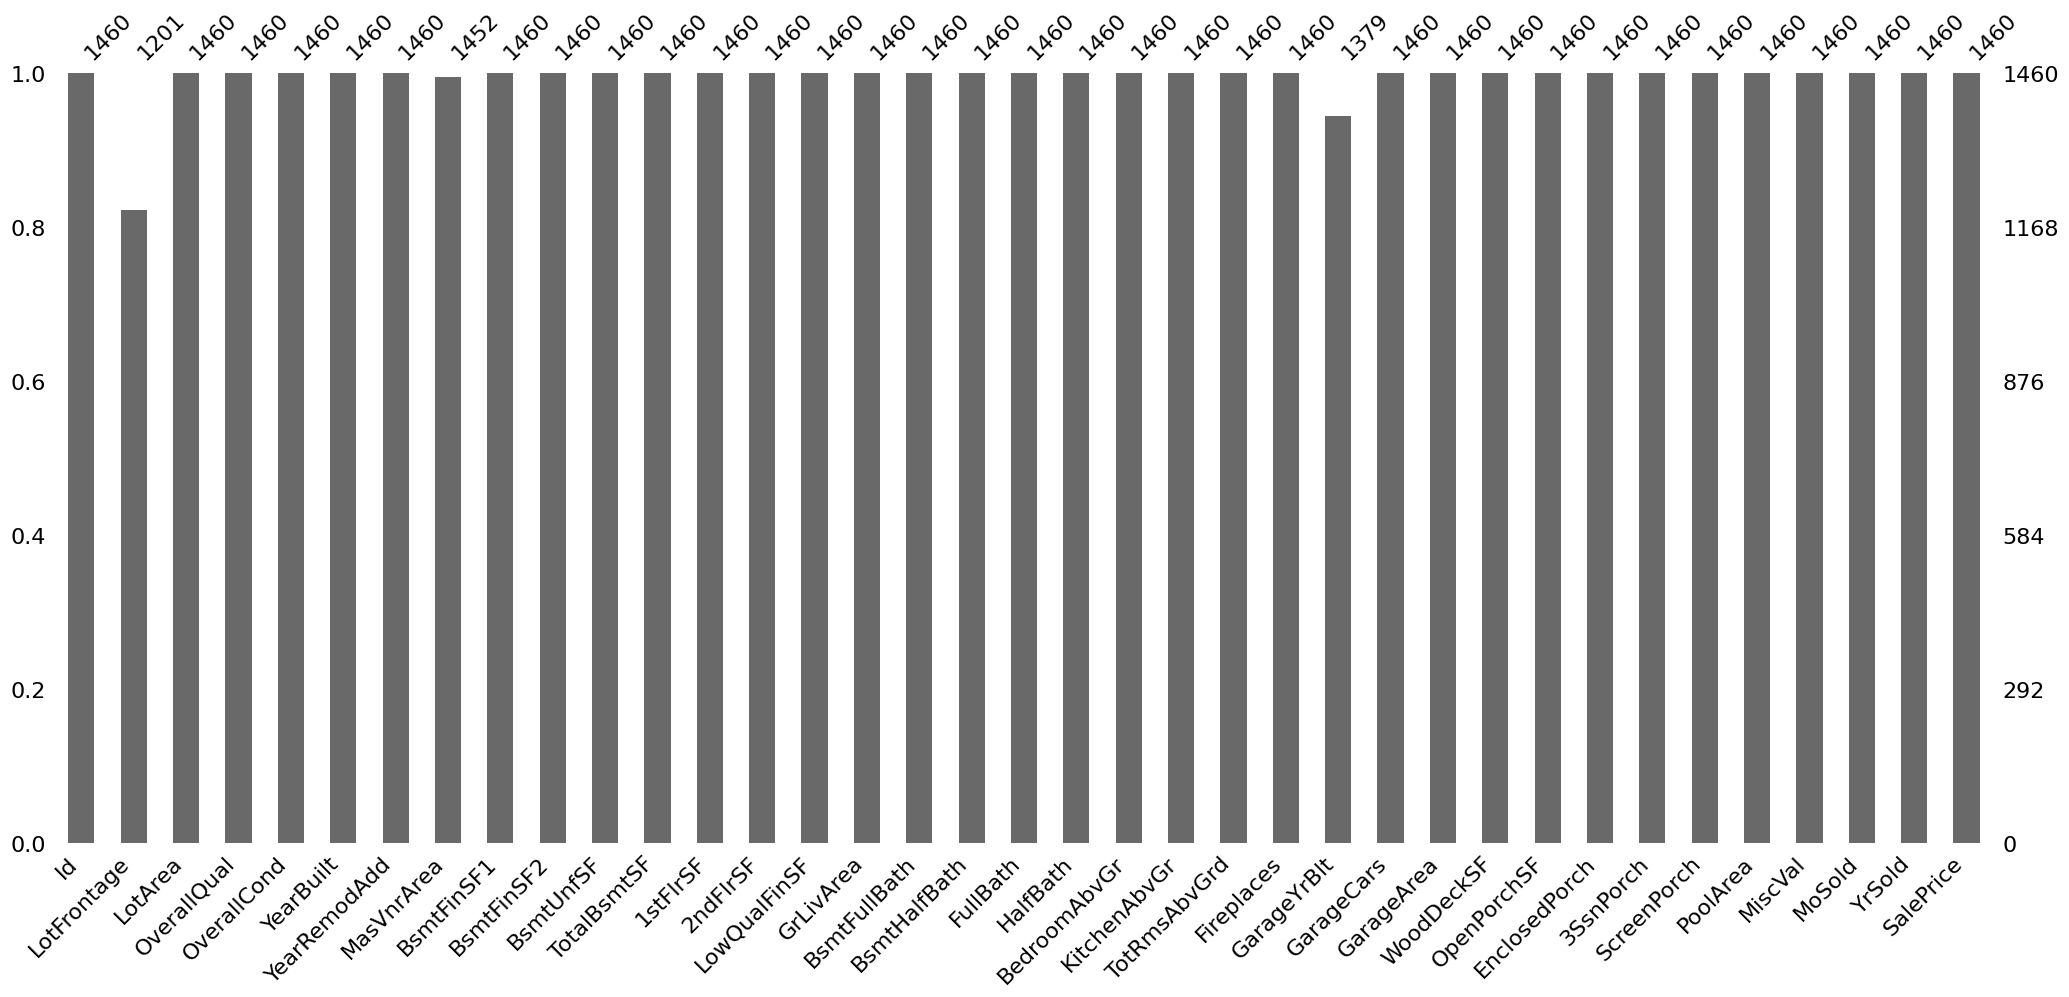

In [3]:
# Filter for numerics
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
raw['MSSubClass'] = raw['MSSubClass'].astype('category')
numerical_data = raw.select_dtypes(include=numerics)
msno.bar(numerical_data)

LotFrontage is n/a if property is not connected to the street.  Fill na's with 0 as with MasVnrArea.  If garage year built is missing then fill with the mean.

In [4]:
# Cleaning
numerical_data.drop('MiscVal', axis=1, inplace=True)
numerical_data[['LotFrontage', 'MasVnrArea']] = numerical_data[['LotFrontage', 'MasVnrArea']].fillna(0)
numerical_data['GarageYrBlt'] = numerical_data['GarageYrBlt'].fillna(numerical_data['GarageYrBlt'].mean()) 

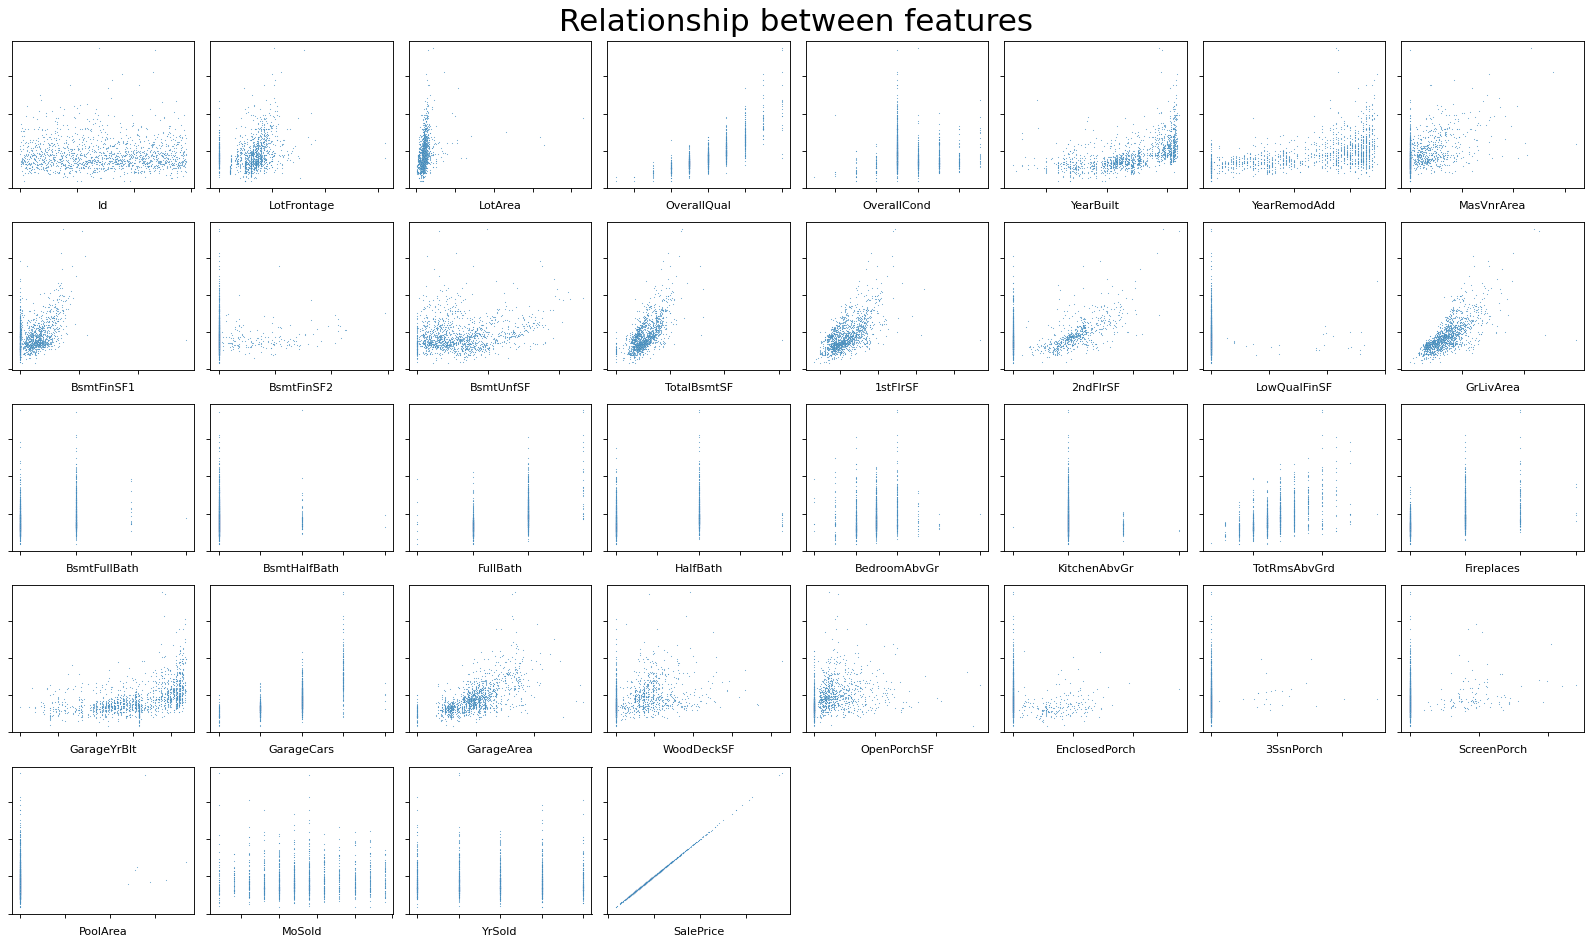

In [5]:
# Figure showing relationship of features against SalePrice
figure(figsize=(20, 12), dpi=80)
for i in range(36):
    ax = plt.subplot(5, 8, i+1)
    sns.scatterplot(numerical_data, x=numerical_data.iloc[:,i], y=numerical_data['SalePrice'], s=1.0, alpha=0.7, ax=ax)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set(xlabel=numerical_data.columns[i], ylabel='')
plt.suptitle('Relationship between features', fontsize=28)
plt.tight_layout()
plt.show()

We tend to see linear relationships across predictors. The most promising looking predictors appear visually to be OverallQual, LotArea, YearBuilt and the square foot (SF) predictors identifying house/room sizes. Now, we'll fit a linear regression model to these predictors, leaving 30% of the data for testing.

In [6]:
# Fit model
X = numerical_data.drop('SalePrice', axis=1)
y = raw['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
reg = LinearRegression().fit(X_train, y_train)
print('Training R^2: {}'.format(reg.score(X_train, y_train)))
print('Testing R^2: {}'.format(reg.score(X_test, y_test)))

Training R^2: 0.8387782192352713
Testing R^2: 0.7123579440739476


On the training data we get an overall R^2 score of 0.84 which only fell to 0.71 on the test data.  This is really good and shows our model is able to explain a large amount of the variabililty with these predictors.  Below we can see more detail about the performance of each predictor individually:

In [7]:
mod = sm.OLS(y_train,X_train)
fii = mod.fit()
print(fii.summary())

                                 OLS Regression Results                                
Dep. Variable:              SalePrice   R-squared (uncentered):                   0.975
Model:                            OLS   Adj. R-squared (uncentered):              0.974
Method:                 Least Squares   F-statistic:                              1150.
Date:                Mon, 13 Mar 2023   Prob (F-statistic):                        0.00
Time:                        17:36:01   Log-Likelihood:                         -12031.
No. Observations:                1022   AIC:                                  2.413e+04
Df Residuals:                     989   BIC:                                  2.429e+04
Df Model:                          33                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

We see that a lot predictors are not statistically significant (possibly because of strong co-linearity with other predictors).  OverallQual, OverallCond, YearBuilt, square foot (SF) values and year sold are some of the better predictors and this matches our visual observations we made before.  Another question you might ask is, 'Do we need all these predictors?' How well can we do with just a few.  RFE (Recursive Feature Elimination) is a method of identifying performance based on a contrained number of predictors.

In [18]:
# Recursive Feature Elimination
scores_train = []
scores_test = []
for i in range(35):
    selector = RFE(Lasso(), n_features_to_select=i+1, step=1)
    selector = selector.fit(X_train, y_train)
    # print(X_train.iloc[:,selector.support_].columns)
    subset_X_train = selector.transform(X_train)
    subset_X_test = selector.transform(X_test)
    lr = LinearRegression()
    lr.fit(subset_X_train, y_train)
    # y_pred_test = lr.predict(subset_X_test)
    # y_pred_train = lr.predict(subset_X_train)
    # score_test = mean_absolute_error(y_test, y_pred_test)
    # score_train = mean_absolute_error(y_train, y_pred_train)
    # print("MAE for {}: {} train & {} test".format(i, score_train, score_test))
    # scores_test.append(score_test)
    # scores_train.append(score_train)
    scores_train.append(lr.score(subset_X_train, y_train))
    scores_test.append(lr.score(subset_X_test, y_test))
    # print("MAE for {}: {} train & {} test".format(i, lr.score(subset_X_test, y_test), lr.score(subset_X_train, y_train)))

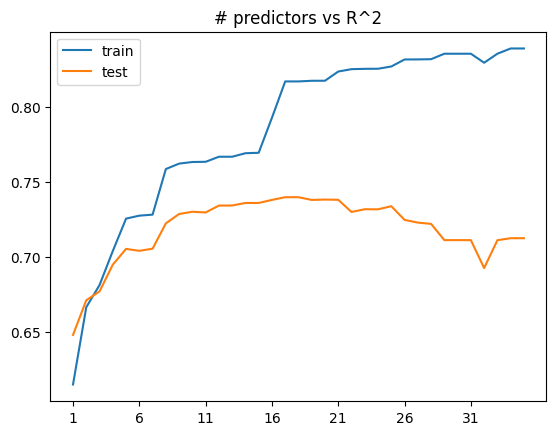

In [19]:
# Plotting
plt.title('# predictors vs R^2')
plt.plot(scores_train, label='train')
# plt.show()
# plt.title('# predictors vs MAE for test data')
plt.plot(scores_test, label='test')
plt.legend()
plt.xticks(np.arange(len(scores_train), step=5), np.arange(1, len(scores_train)+1, step=5))
plt.show()

Initially, a single predictor is capable of capturing about 60% of the variance.  We see that for the test data additional predictors make no real difference to predictive power after about 15 predictors.  In addition, there appears to be a sweet spot of about 5 predictors which given a relatively few number of predictors still gives a good R^2 score.  These predictors are:

'OverallQual', 'BsmtFullBath', 'FullBath', 'Fireplaces', 'GarageCars'